In [1]:
import pandas as pd
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
#open nyc crimes data
ny = pd.read_csv('ny_fin.csv')
ny.head()

/var/folders/5w/m_qj7nx12w1_jrs1bnq0yfgh0000gn/T/ipykernel_10218/1013792969.py:2: DtypeWarning: Columns (17,18,29) have mixed types. Specify dtype option on import or set low_memory=False.
  ny = pd.read_csv('ny_fin.csv')


,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,ofns_desc,crm_atpt_cptd_cd,law_cat_cd,boro_nm,loc_of_occur_desc,prem_typ_desc,susp_age_group,...,DAY_OF_WEEK,MONTH,HOUR,Season,Number,Street,City,State,Zip,Country
0,932184137,2016-01-01 00:00:00,2021-11-11 00:00:00,SEX CRIMES,COMPLETED,FELONY,MANHATTAN,INSIDE,RESIDENCE - APT. HOUSE,45-64,...,Thu,1,0,Winter,4295,Broadway,New York,NY,10033,US
1,506003829,2016-01-01 00:00:00,2021-11-11 21:00:00,SEX CRIMES,COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,RESIDENCE - APT. HOUSE,25-44,...,Thu,1,21,Winter,321,East 5th Street,New York,NY,10003,US
2,614924322,2016-01-01 00:00:00,2021-11-11 00:01:00,GRAND LARCENY,COMPLETED,FELONY,MANHATTAN,INSIDE,BANK,UNKNOWN,...,Thu,1,0,Winter,100,Park Avenue,New York,NY,10016,US
3,405538879,2016-01-01 00:00:00,2021-11-11 17:00:00,OFF. AGNST PUB ORD SENSBLTY &,COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,RESIDENCE - APT. HOUSE,UNKNOWN,...,Thu,1,17,Winter,400,West 59th Street,New York,NY,10019,US
4,983297347,2016-01-01 00:00:00,2021-11-11 08:00:00,SEX CRIMES,ATTEMPTED,FELONY,MANHATTAN,INSIDE,RESIDENCE - PUBLIC HOUSING,UNKNOWN,...,Thu,1,8,Winter,162,East 102nd Street,New York,NY,10029,US


In [3]:
#convert to dictionary to append neighborhood names
ny_dict = ny.to_dict('records')
ny_dict

[{'cmplnt_num': 932184137,
  'cmplnt_fr_dt': '2016-01-01 00:00:00',
  'cmplnt_fr_tm': '2021-11-11 00:00:00',
  'ofns_desc': 'SEX CRIMES',
  'crm_atpt_cptd_cd': 'COMPLETED',
  'law_cat_cd': 'FELONY',
  'boro_nm': 'MANHATTAN',
  'loc_of_occur_desc': 'INSIDE',
  'prem_typ_desc': 'RESIDENCE - APT. HOUSE',
  'susp_age_group': '45-64',
  'susp_race': 'WHITE HISPANIC',
  'susp_sex': 'M',
  'latitude': 40.85148777400008,
  'longitude': -73.93545796699993,
  'vic_age_group': '<18',
  'vic_race': 'BLACK HISPANIC',
  'vic_sex': 'F',
  'station_name': nan,
  'parks_nm': nan,
  'YEAR': 2016,
  'DAY': 1,
  'DAY_OF_WEEK': 'Thu',
  'MONTH': 1,
  'HOUR': 0,
  'Season': 'Winter',
  'Number': '4295',
  'Street': 'Broadway',
  'City': 'New York',
  'State': 'NY',
  'Zip': '10033',
  'Country': 'US'},
 {'cmplnt_num': 506003829,
  'cmplnt_fr_dt': '2016-01-01 00:00:00',
  'cmplnt_fr_tm': '2021-11-11 21:00:00',
  'ofns_desc': 'SEX CRIMES',
  'crm_atpt_cptd_cd': 'COMPLETED',
  'law_cat_cd': 'MISDEMEANOR',
  'b

In [4]:
#open new york neighborhood data
with open('nyu-2451-34572-geojson.json') as fh:
    data = fh.read()
    neighbor = json.loads(data)
neighbor

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
#check each crime
for crime in ny_dict:
    #set default value for distance
    mini = 100
    neighborhood = str() #initiate neighborhood variable
    for hood in neighbor['features']:#for each neighborhood check to see the total distance of lat/lon from the crime lat/lon
        distance = math.fabs(crime['latitude'] - hood['geometry']['coordinates'][1]) + math.fabs(crime['longitude'] - hood['geometry']['coordinates'][0])
        if distance < mini: #if distance is less than the current smallest, set neighborhood to the current neighborhood
            neighborhood = hood['properties']['name']
            mini = distance
    crime['neighborhood'] = neighborhood #append neighborhood w/ smallest distance to crime instance

In [6]:
#convert back to dataframe to work with
n_ny = pd.DataFrame.from_dict(ny_dict)
#save dataset for future use
n_ny.to_csv('ny_nbrhd.csv')

##### Note from NYPD dataset info
"To further protect victim identities, rape and sex crime offenses have been
located as occurring at the police station house within the precinct of
occurrence"

In [7]:
#remove items related to sex crimes due to above note
fsc_mask = [i != 'SEX CRIMES' and i != 'RAPE' and i!= 'FELONY SEX CRIMES' for i in n_ny.ofns_desc]
n_ny[fsc_mask]

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,ofns_desc,crm_atpt_cptd_cd,law_cat_cd,boro_nm,loc_of_occur_desc,prem_typ_desc,susp_age_group,...,MONTH,HOUR,Season,Number,Street,City,State,Zip,Country,neighborhood
2,614924322,2016-01-01 00:00:00,2021-11-11 00:01:00,GRAND LARCENY,COMPLETED,FELONY,MANHATTAN,INSIDE,BANK,UNKNOWN,...,1,0,Winter,100,Park Avenue,New York,NY,10016,US,Murray Hill
3,405538879,2016-01-01 00:00:00,2021-11-11 17:00:00,OFF. AGNST PUB ORD SENSBLTY &,COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,RESIDENCE - APT. HOUSE,UNKNOWN,...,1,17,Winter,400,West 59th Street,New York,NY,10019,US,Lincoln Square
5,235290134,2016-01-01 00:00:00,2021-11-11 12:00:00,HARRASSMENT 2,COMPLETED,VIOLATION,MANHATTAN,INSIDE,PHOTO/COPY,45-64,...,1,12,Winter,100,Jane Street,New York,NY,10014,US,West Village
7,938775913,2016-01-01 00:00:00,2021-11-11 17:15:00,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,DEPARTMENT STORE,<18,...,1,17,Winter,1960,Broadway,New York,NY,10023,US,Lincoln Square
8,932337415,2016-01-01 00:00:00,2021-11-11 22:00:00,GRAND LARCENY,COMPLETED,FELONY,MANHATTAN,NaN,STREET,UNKNOWN,...,1,22,Winter,55,East 52nd Street,New York,NY,10055,US,Sutton Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261486,965063098,2020-12-31 00:00:00,2021-11-11 03:00:00,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,STATEN ISLAND,NaN,STREET,UNKNOWN,...,12,3,Winter,116,Main Street,New York,NY,10307.0,US,Tottenville
2261487,909024894,2020-12-31 00:00:00,2021-11-11 23:00:00,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,STATEN ISLAND,INSIDE,RESIDENCE-HOUSE,25-44,...,12,23,Winter,33,South Street,New York,NY,10310.0,US,West Brighton
2261488,794056017,2020-12-31 00:00:00,2021-11-11 14:17:00,PETIT LARCENY,COMPLETED,MISDEMEANOR,STATEN ISLAND,REAR OF,DEPARTMENT STORE,25-44,...,12,14,Winter,24,Bay Street,New York,NY,10301.0,US,St. George
2261489,272635355,2020-12-31 00:00:00,2021-11-11 11:55:00,ROBBERY,COMPLETED,FELONY,STATEN ISLAND,INSIDE,COMMERCIAL BUILDING,25-44,...,12,11,Winter,78,Richmond Terrace,New York,NY,10301.0,US,St. George


### More Preprocessing

In [8]:
#removing items that are n/a, redundant, or may not be known beforehand
df = n_ny[fsc_mask].drop(['cmplnt_num', 'cmplnt_fr_dt', 'cmplnt_fr_tm', 'ofns_desc',
       'crm_atpt_cptd_cd',
       'prem_typ_desc', 'susp_age_group', 'susp_race', 'susp_sex',
       'station_name',
       'parks_nm', 'Season',
       'Number', 'City', 'State', 'Zip', 'Country'], axis=1)

#cleaning up location of occurrence
df['loc_of_occur_desc'].fillna(value = 'N/A', inplace = True)
df['loc_code'] = df['loc_of_occur_desc'].map({'INSIDE': 'Inside', 'FRONT OF': 'Outside', 'OPPOSITE OF': 'Outside', 'REAR OF': 'Outside', 'N/A': 'Unknown'})

#grouping unknown sex into one category
df['vics_code'] = df['vic_sex'].map({'M': 'M', 'F': 'F','D': 'U', 'E': 'U'})

#quick mapping for age and race to account for same variable name
df['vica_code'] = df['vic_age_group'].map({'<18':'<18', '25-44':'25-44', 'UNKNOWN': 'Unknown_Age', '45-64':'45-64', '18-24':'18-24', '65+':'65+'})
                                          
df['vicr_code'] = df['vic_race'].map({'BLACK HISPANIC': 'BLACK HISPANIC', 'ASIAN / PACIFIC ISLANDER': 'ASIAN / PACIFIC ISLANDER', 'UNKNOWN': 'UNKNOWN', 'WHITE':'WHITE',
       'BLACK': 'BLACK', 'WHITE HISPANIC': 'WHITE HISPANIC', 'AMERICAN INDIAN/ALASKAN NATIVE' : 'AMERICAN INDIAN/ALASKAN NATIVE'})                                        
                                          

In [9]:
#one hot encode some categorical variables (with minimal categories)
loc_ = pd.get_dummies(df.loc_code)
df = pd.concat([df,loc_], axis=1)

boro_ = pd.get_dummies(df.boro_nm)
df = pd.concat([df,boro_],axis=1)

dow_ = pd.get_dummies(df.DAY_OF_WEEK)
df = pd.concat([df, dow_],axis=1)

vicr_ = pd.get_dummies(df.vicr_code)
df = pd.concat([df, vicr_],axis=1)

vics_ = pd.get_dummies(df.vics_code)
df = pd.concat([df, vics_],axis=1)

vica_ = pd.get_dummies(df.vica_code)
df = pd.concat([df, vica_],axis=1)

In [10]:
#label encode others which provide too many categories for one hot encoding

#category code (target variable)
df['cat_code'] = df['law_cat_cd'].map({'FELONY': 2, 'MISDEMEANOR': 1, 'VIOLATION': 0})

#neighborhood
hood_dict = dict()
hood_dict = {ix:i for i,ix in enumerate(df['neighborhood'].unique())}
df['hood_cd'] = df['neighborhood'].map(hood_dict)

#street
street_dict = dict()
street_dict = {ix:i for i,ix in enumerate(df['Street'].unique())}
df['street_cd'] = df['Street'].map(street_dict)

In [11]:
df

,law_cat_cd,boro_nm,loc_of_occur_desc,latitude,longitude,vic_age_group,vic_race,vic_sex,YEAR,DAY,...,U,18-24,25-44,45-64,65+,<18,Unknown_Age,cat_code,hood_cd,street_cd
2,FELONY,MANHATTAN,INSIDE,40.751192,-73.978357,UNKNOWN,UNKNOWN,F,2016,1,...,0,0,0,0,0,0,1,2,0,0
3,MISDEMEANOR,MANHATTAN,INSIDE,40.768919,-73.984990,45-64,WHITE,M,2016,1,...,0,0,0,1,0,0,0,1,1,1
5,VIOLATION,MANHATTAN,INSIDE,40.737857,-74.008182,25-44,WHITE,F,2016,1,...,0,0,1,0,0,0,0,0,2,2
7,MISDEMEANOR,MANHATTAN,INSIDE,40.774238,-73.982101,UNKNOWN,UNKNOWN,D,2016,1,...,1,0,0,0,0,0,1,1,1,3
8,FELONY,MANHATTAN,N/A,40.758803,-73.973925,45-64,WHITE,M,2016,1,...,0,0,0,1,0,0,0,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261486,MISDEMEANOR,STATEN ISLAND,N/A,40.511804,-74.250035,UNKNOWN,UNKNOWN,E,2020,31,...,1,0,0,0,0,0,1,1,244,139
2261487,MISDEMEANOR,STATEN ISLAND,INSIDE,40.633520,-74.115632,25-44,BLACK,F,2020,31,...,0,0,1,0,0,0,0,1,258,51
2261488,MISDEMEANOR,STATEN ISLAND,REAR OF,40.641738,-74.075678,UNKNOWN,WHITE HISPANIC,D,2020,31,...,1,0,0,0,0,0,1,1,245,1065
2261489,FELONY,STATEN ISLAND,INSIDE,40.644726,-74.077483,UNKNOWN,UNKNOWN,D,2020,31,...,1,0,0,0,0,0,1,2,245,4997


In [12]:
#removing mapped categories
df = df.drop(['boro_nm', 'DAY_OF_WEEK', 'Street', 'law_cat_cd', 'loc_of_occur_desc', 'loc_code', 'neighborhood', 'vic_age_group', 'vic_race', 'vic_sex', 'vics_code', 'vica_code','vicr_code'], axis = 1)

df.head()

,latitude,longitude,YEAR,DAY,MONTH,HOUR,Inside,Outside,Unknown,BRONX,...,U,18-24,25-44,45-64,65+,<18,Unknown_Age,cat_code,hood_cd,street_cd
2,40.751192,-73.978357,2016,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,2,0,0
3,40.768919,-73.984990,2016,1,1,17,1,0,0,0,...,0,0,0,1,0,0,0,1,1,1
5,40.737857,-74.008182,2016,1,1,12,1,0,0,0,...,0,0,1,0,0,0,0,0,2,2
7,40.774238,-73.982101,2016,1,1,17,1,0,0,0,...,1,0,0,0,0,0,1,1,1,3
8,40.758803,-73.973925,2016,1,1,22,0,0,1,0,...,0,0,0,1,0,0,0,2,3,4


<AxesSubplot:>

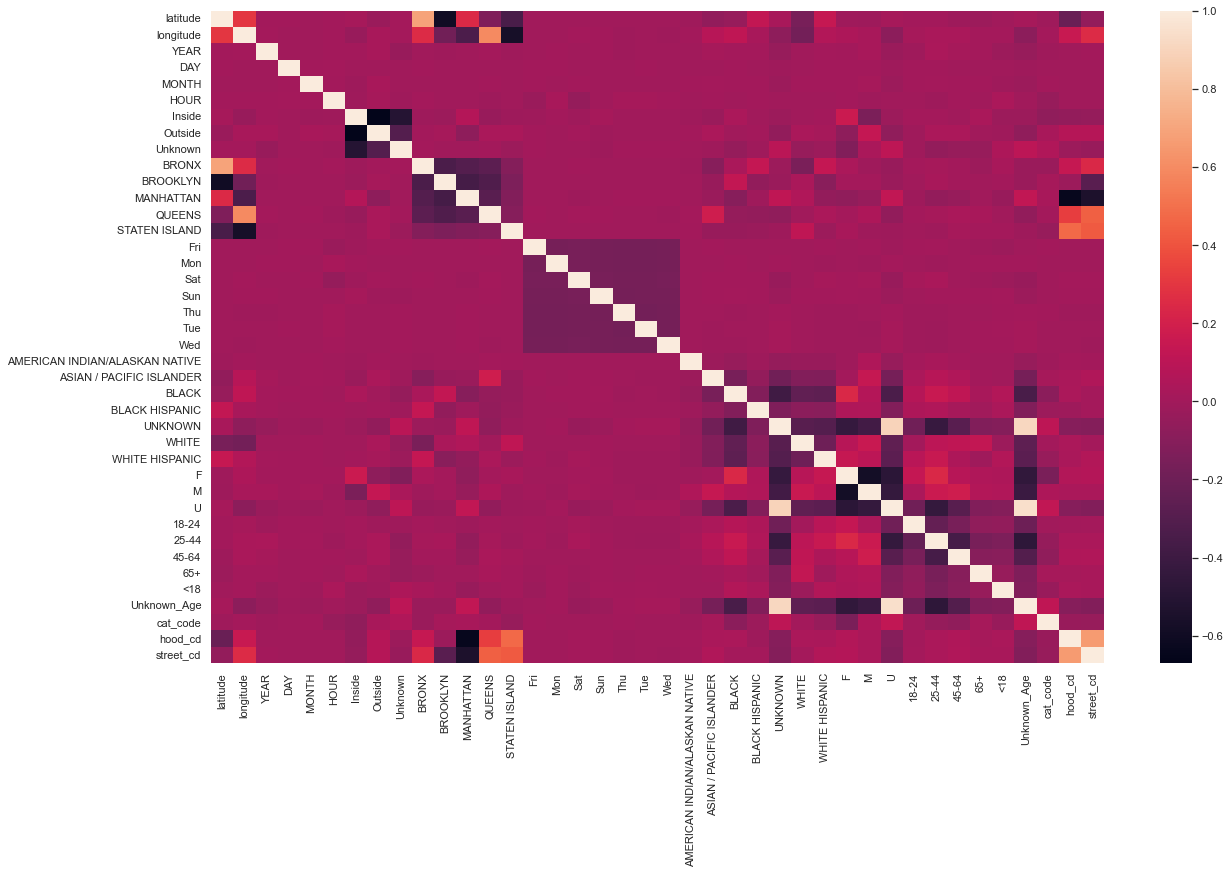

In [13]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(df.corr())

We have higher correlation surrounding location based variables - this is expected. In general we see generally higher correlation with the boro variables

We also have high correlation for Unknown victim information. This is expected as well (if we don't have the victim's sex we most likely don't have the victim's race or age either)

In [14]:
df.columns

Index(['latitude', 'longitude', 'YEAR', 'DAY', 'MONTH', 'HOUR', 'Inside',
       'Outside', 'Unknown', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS',
       'STATEN ISLAND', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed',
       'AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK',
       'BLACK HISPANIC', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC', 'F', 'M', 'U',
       '18-24', '25-44', '45-64', '65+', '<18', 'Unknown_Age', 'cat_code',
       'hood_cd', 'street_cd'],
      dtype='object')

In [38]:
df2 = df.drop(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS',
       'STATEN ISLAND', 'latitude', 'longitude'], axis = 1)

In [16]:
df2.head()

,YEAR,DAY,MONTH,HOUR,Inside,Outside,Unknown,Fri,Mon,Sat,...,U,18-24,25-44,45-64,65+,<18,Unknown_Age,cat_code,hood_cd,street_cd
2,2016,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,2,0,0
3,2016,1,1,17,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1
5,2016,1,1,12,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2,2
7,2016,1,1,17,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1,1,3
8,2016,1,1,22,0,0,1,0,0,0,...,0,0,0,1,0,0,0,2,3,4


In [17]:
df2.to_csv('ohcl_ny.csv')

In [39]:
y = df2['cat_code']
x = df2.drop(['cat_code'], axis = 1)

In [40]:
X_train, X_test, y_train,y_test = train_test_split(x, y, test_size=.3, random_state=42)

### Naive Bayes

In [20]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
nb_y_pred = mnb.predict(X_test)

In [21]:
print(classification_report(y_test,nb_y_pred))

              precision    recall  f1-score   support

           0       0.17      0.41      0.24    102336
           1       0.60      0.13      0.22    358418
           2       0.32      0.52      0.39    206597

    accuracy                           0.30    667351
   macro avg       0.36      0.36      0.28    667351
weighted avg       0.45      0.30      0.28    667351



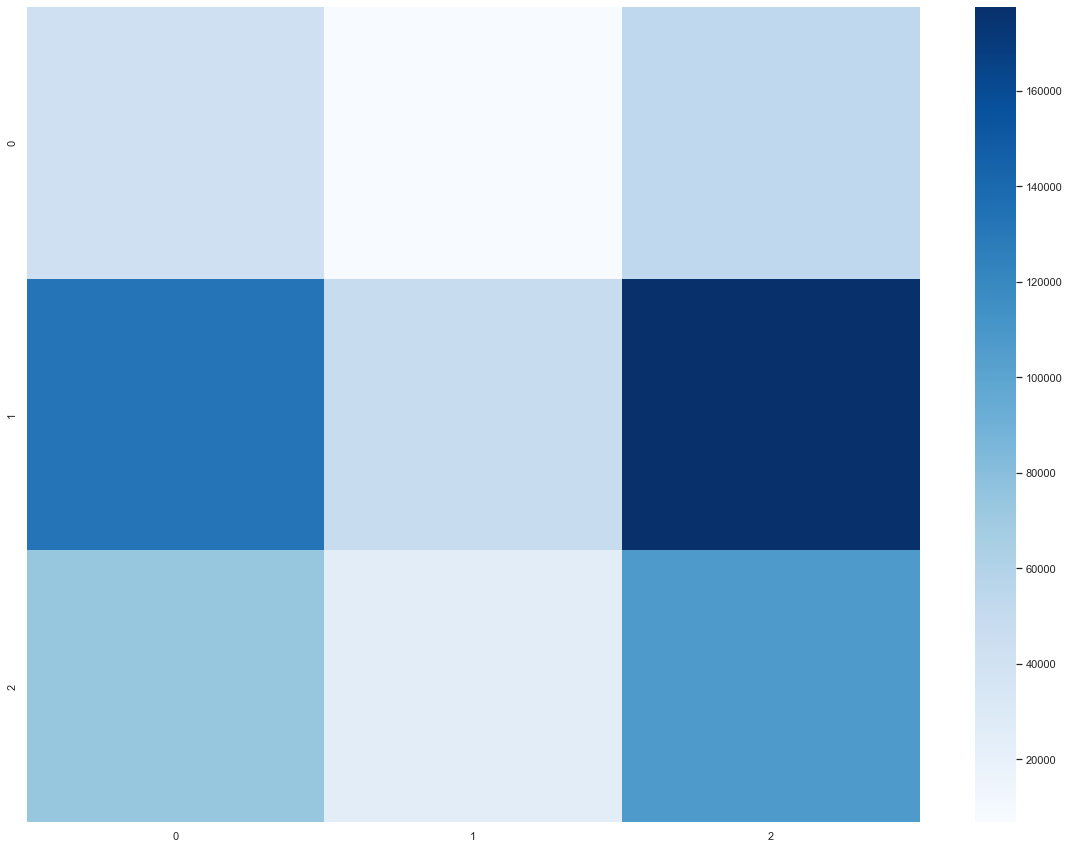

In [31]:
matrix = confusion_matrix(y_test,nb_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Decision Tree

In [23]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree_y_pred = clf.predict(X_test)

In [24]:
print(classification_report(y_test,tree_y_pred))

              precision    recall  f1-score   support

           0       0.25      0.26      0.25    102336
           1       0.58      0.57      0.57    358418
           2       0.36      0.36      0.36    206597

    accuracy                           0.46    667351
   macro avg       0.40      0.40      0.40    667351
weighted avg       0.46      0.46      0.46    667351



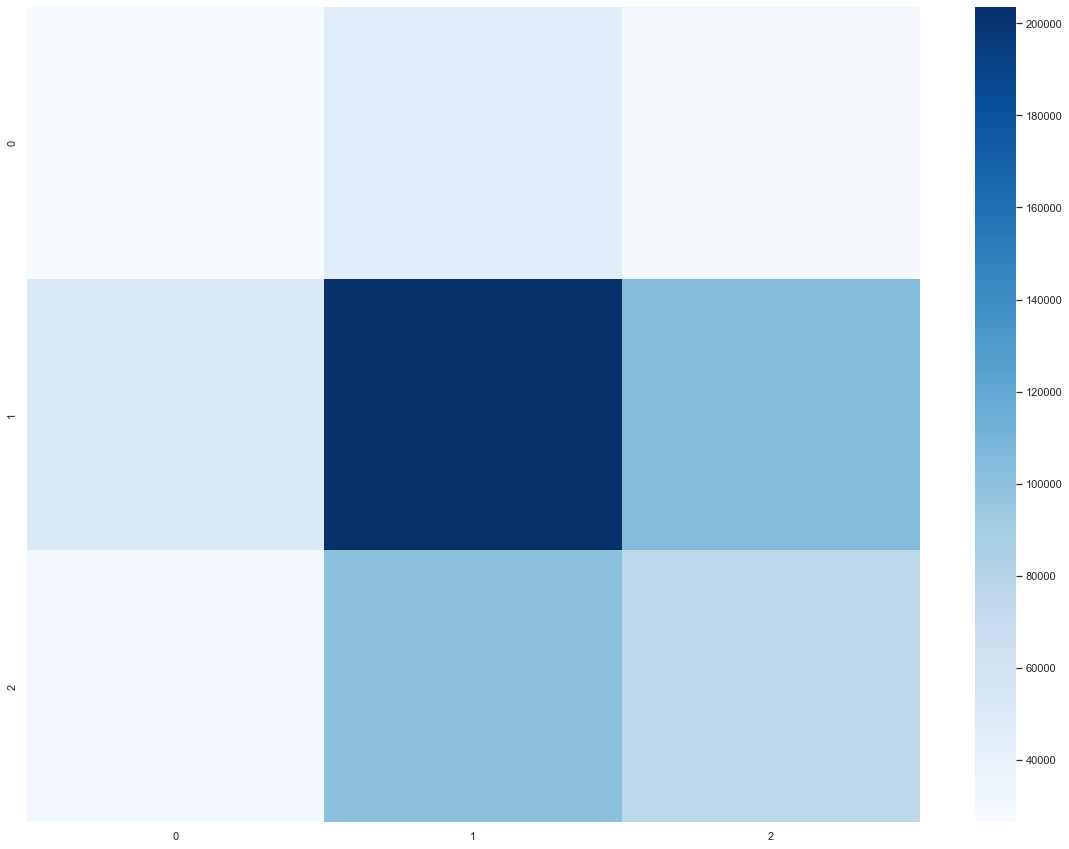

In [32]:
matrix = confusion_matrix(y_test,tree_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Adaptive Boosting Decision Tree

In [26]:
abc = AdaBoostClassifier(n_estimators=100,learning_rate=.5)

model = abc.fit(X_train, y_train)
ada_y_pred = model.predict(X_test)

In [27]:
print(classification_report(y_test,ada_y_pred))

              precision    recall  f1-score   support

           0       0.34      0.01      0.01    102336
           1       0.54      0.97      0.70    358418
           2       0.46      0.05      0.09    206597

    accuracy                           0.54    667351
   macro avg       0.45      0.34      0.27    667351
weighted avg       0.49      0.54      0.40    667351



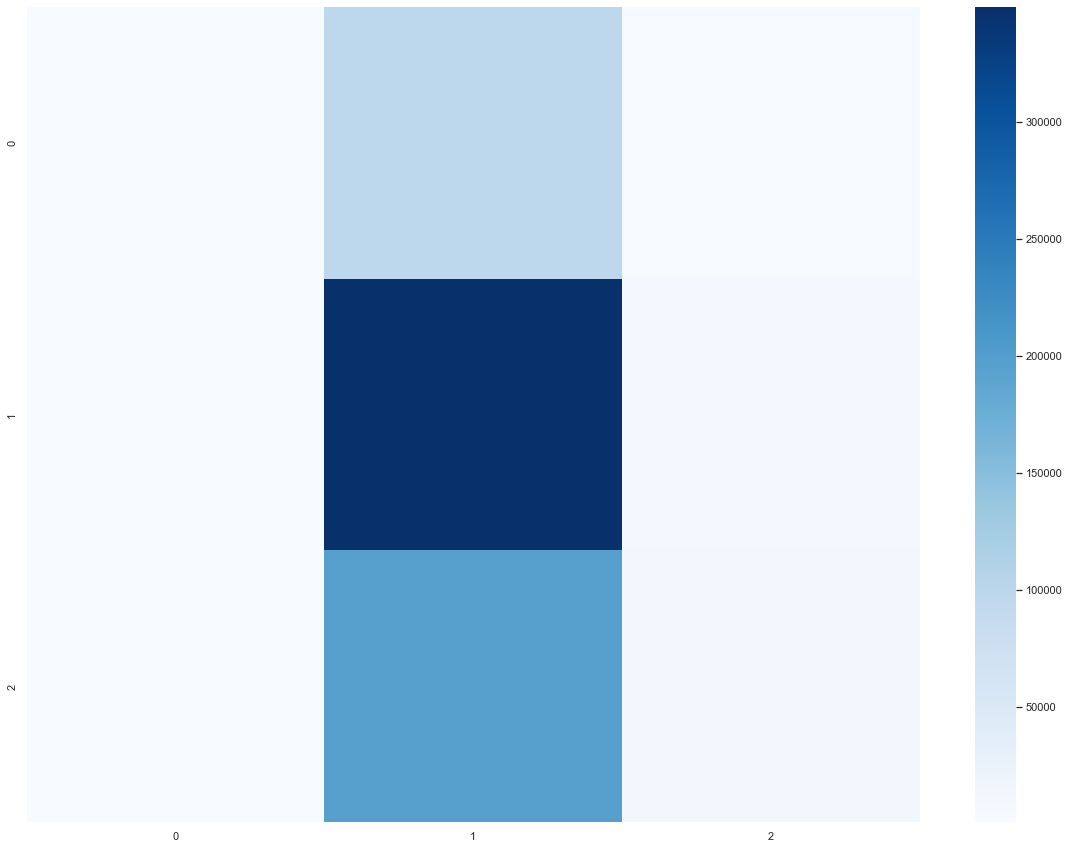

In [33]:
matrix = confusion_matrix(y_test,ada_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

In [36]:
print(classification_report(y_test,rf_y_pred))

              precision    recall  f1-score   support

           0       0.32      0.11      0.17    102336
           1       0.57      0.81      0.67    358418
           2       0.43      0.25      0.32    206597

    accuracy                           0.53    667351
   macro avg       0.44      0.39      0.38    667351
weighted avg       0.49      0.53      0.48    667351



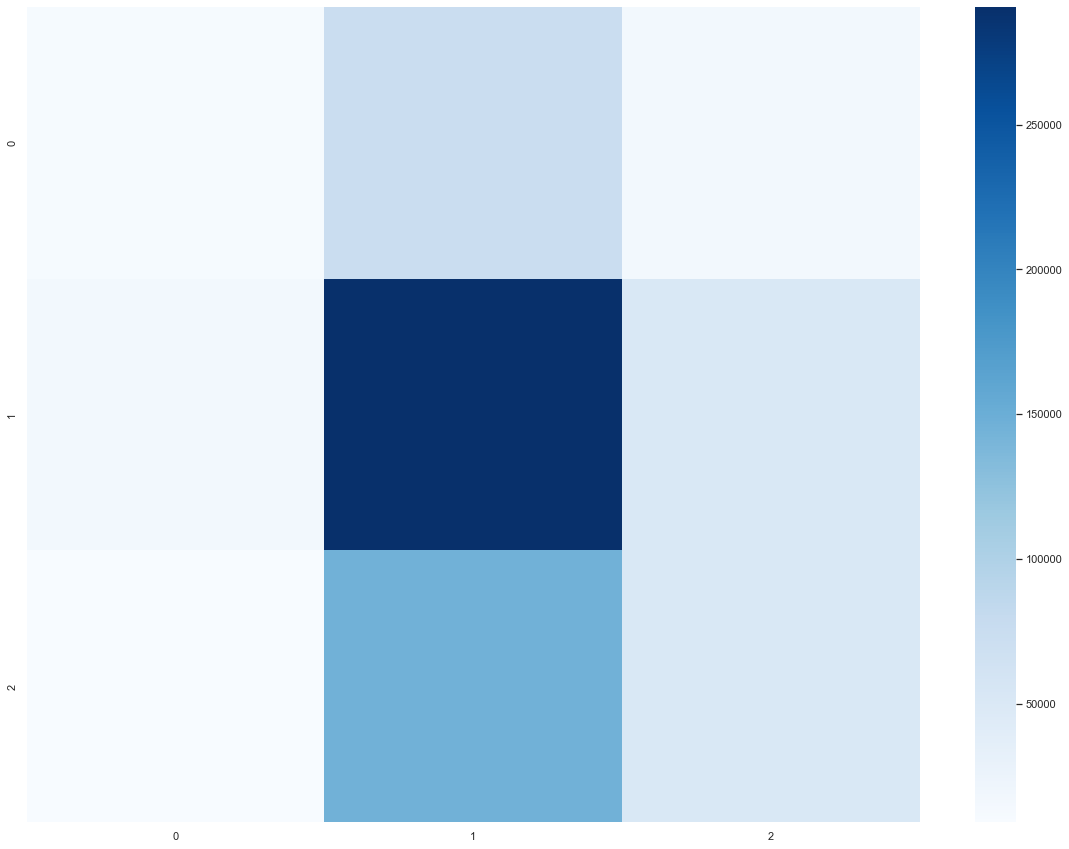

In [37]:
matrix = confusion_matrix(y_test, rf_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### K-Nearest Neighbors

Warning: KNN takes awhile to run, comment out if needed.

In [39]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test,knn_y_pred))

In [ ]:
matrix = confusion_matrix(y_test, knn_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

## Trying something else (Run #2)

In [ ]:
#since there are some variables in the dataset that are unknown, these could be skewing data. We'll try to remove
#them and run our models (victim race, age, sex)
df3 = df2.drop(['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK',
       'BLACK HISPANIC', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC', 'F', 'M', 'U',
       '18-24', '25-44', '45-64', '65+', '<18', 'Unknown_Age',], axis = 1)

In [ ]:
df3.to_csv('ohcl_ny2.csv')

In [ ]:
y = df3['cat_code']
x = df3.drop(['cat_code'], axis = 1)

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(x, y, test_size=.3, random_state=42)

### Naive Bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
nb_y_pred = mnb.predict(X_test)

In [ ]:
print(classification_report(y_test,nb_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,nb_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Decision Tree

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree_y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test,tree_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,tree_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Adaptive Boosting Decision Tree

In [ ]:
abc = AdaBoostClassifier(n_estimators=100,learning_rate=.5)

model = abc.fit(X_train, y_train)
ada_y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test,ada_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,ada_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test,rf_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,rf_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### K-Nearest Neighbors

Warning: KNN takes awhile to run, comment out if needed.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

In [ ]:
print(classification_report(y_test,knn_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,knn_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

No improvement to metrics. Similar accuracy, but we lose recall for some metrics

## One last try w/ variables - Run #3

In [ ]:
#using lat/lon instead of neighborhood. still removing boro bc of high correlation
df4 = df.drop(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS',
       'STATEN ISLAND', 'hood_cd'], axis = 1)

In [ ]:
df4.to_csv('ohcl_ny3.csv')

In [ ]:
y = df4['cat_code']
x = df4.drop(['cat_code'], axis = 1)

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(x, y, test_size=.3, random_state=42)

### Naive Bayes

We are unable to use NB because there are negative values in the "latitude"/"longitude" datapoints

### Decision Tree

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree_y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test,tree_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,tree_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Adaptive Boosting Decision Tree

In [ ]:
abc = AdaBoostClassifier(n_estimators=100,learning_rate=.5)

model = abc.fit(X_train, y_train)
ada_y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test,ada_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,ada_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test,rf_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,rf_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### K-Nearest Neighbors

Warning: KNN takes awhile to run, comment out if needed.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

In [ ]:
print(classification_report(y_test,knn_y_pred))

In [ ]:
matrix = confusion_matrix(y_test,knn_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

## Playing around some more - Unbalanced Dataset

In [18]:
cat_mask = [i != 0 for i in df2.cat_code]
df2 = df2[cat_mask]
df2.head()

,YEAR,DAY,MONTH,HOUR,Inside,Outside,Unknown,Fri,Mon,Sat,...,U,18-24,25-44,45-64,65+,<18,Unknown_Age,cat_code,hood_cd,street_cd
2,2016,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,2,0,0
3,2016,1,1,17,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,1
7,2016,1,1,17,1,0,0,0,0,0,...,1,0,0,0,0,0,1,1,1,3
8,2016,1,1,22,0,0,1,0,0,0,...,0,0,0,1,0,0,0,2,3,4
9,2016,1,1,8,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,4,5


In [19]:
df2.to_csv('ohcl_ny4.csv')

<AxesSubplot:>

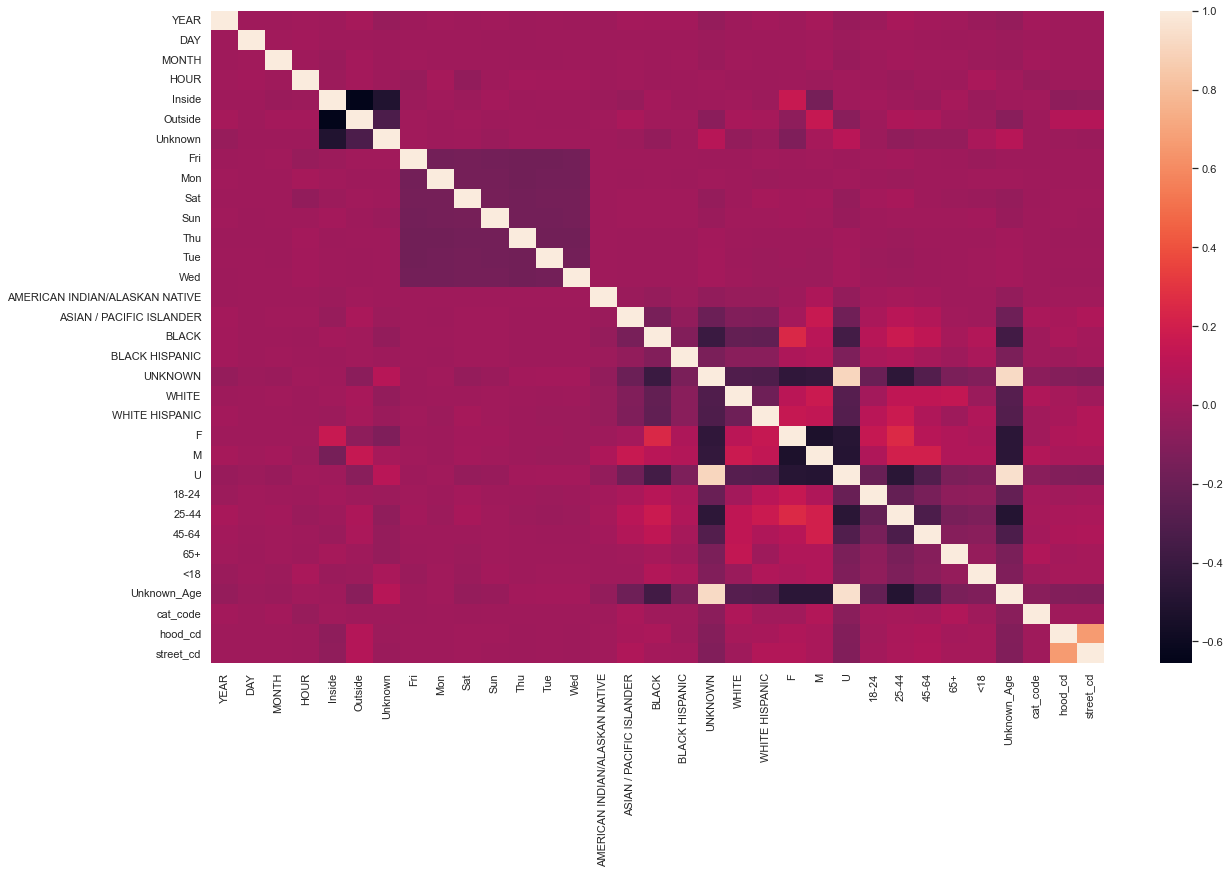

In [20]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(df2.corr())

In [21]:
y = df2['cat_code']
x = df2.drop(['cat_code'], axis = 1)

In [22]:
X_train, X_test, y_train,y_test = train_test_split(x, y, test_size=.3, random_state=42)

### Naive Bayes

In [23]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
nb_y_pred = mnb.predict(X_test)

In [24]:
print(classification_report(y_test,nb_y_pred))

              precision    recall  f1-score   support

           1       0.65      0.85      0.74    358743
           2       0.44      0.21      0.28    205779

    accuracy                           0.62    564522
   macro avg       0.55      0.53      0.51    564522
weighted avg       0.58      0.62      0.57    564522



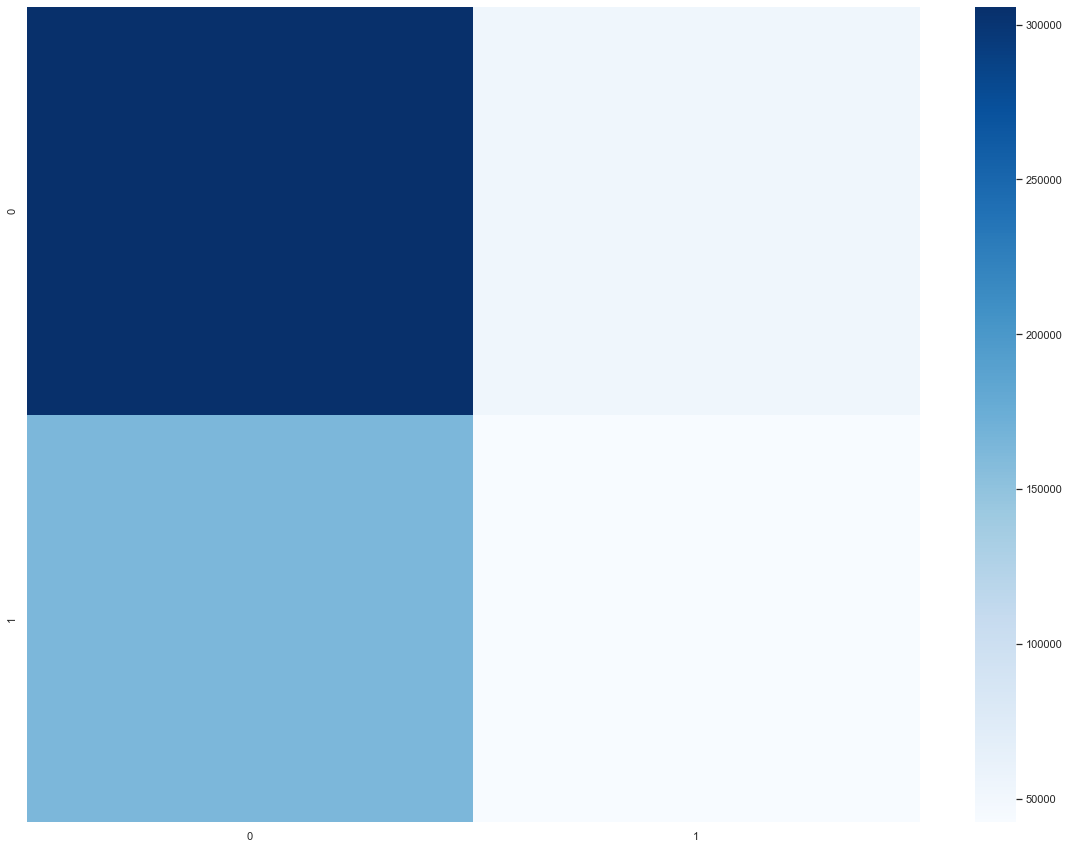

In [25]:
matrix = confusion_matrix(y_test,nb_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Decision Tree

In [26]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
tree_y_pred = clf.predict(X_test)

In [27]:
print(classification_report(y_test,tree_y_pred))

              precision    recall  f1-score   support

           1       0.67      0.65      0.66    358743
           2       0.41      0.43      0.42    205779

    accuracy                           0.57    564522
   macro avg       0.54      0.54      0.54    564522
weighted avg       0.57      0.57      0.57    564522



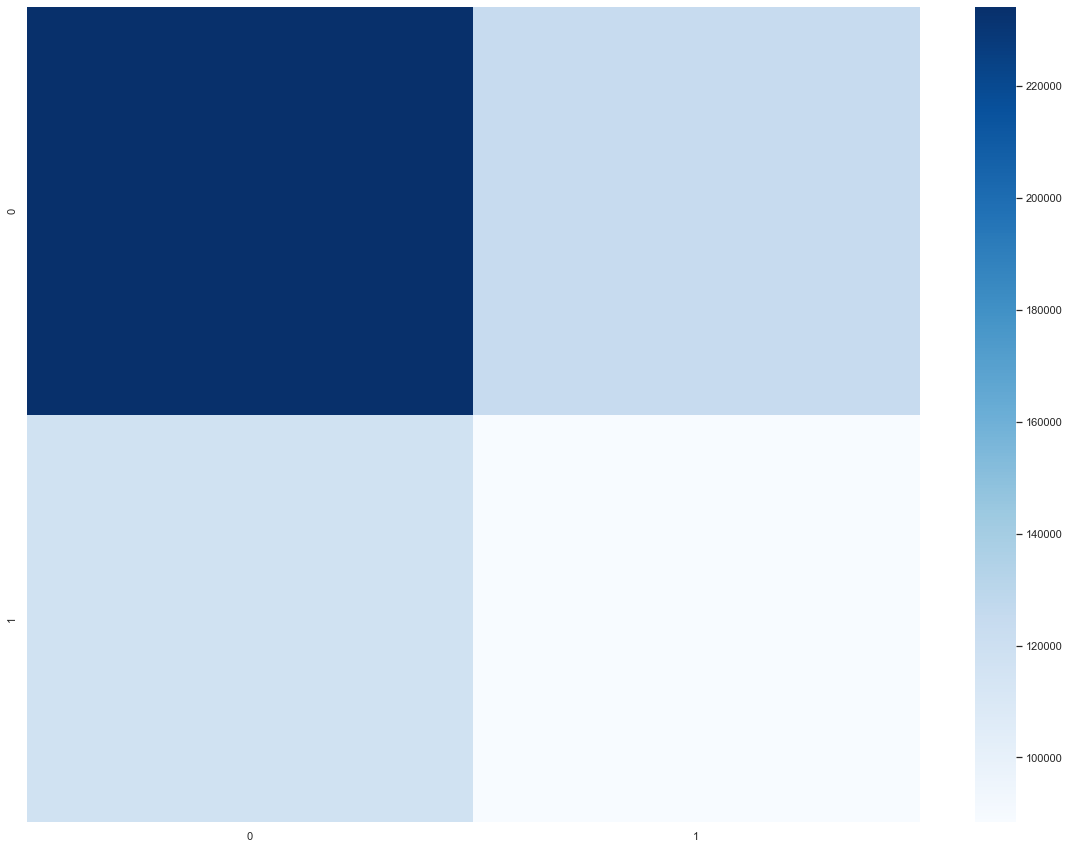

In [28]:
matrix = confusion_matrix(y_test,tree_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Adaptive Boosting Decision Tree

In [29]:
abc = AdaBoostClassifier(n_estimators=100,learning_rate=.5)

model = abc.fit(X_train, y_train)
ada_y_pred = model.predict(X_test)

In [30]:
print(classification_report(y_test,ada_y_pred))

              precision    recall  f1-score   support

           1       0.64      0.98      0.77    358743
           2       0.54      0.05      0.09    205779

    accuracy                           0.64    564522
   macro avg       0.59      0.51      0.43    564522
weighted avg       0.60      0.64      0.52    564522



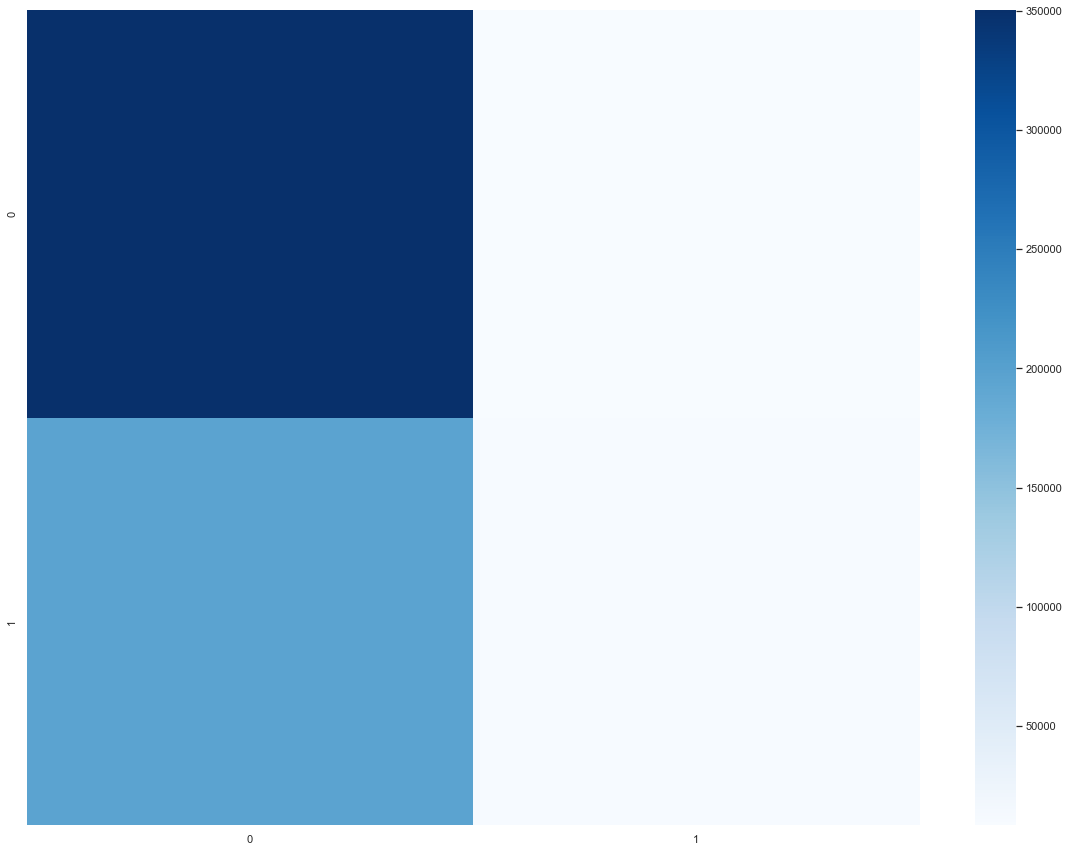

In [31]:
matrix = confusion_matrix(y_test,ada_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### Random Forest

In [32]:
rf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

In [33]:
print(classification_report(y_test,rf_y_pred))

              precision    recall  f1-score   support

           1       0.67      0.86      0.75    358743
           2       0.51      0.24      0.33    205779

    accuracy                           0.64    564522
   macro avg       0.59      0.55      0.54    564522
weighted avg       0.61      0.64      0.60    564522



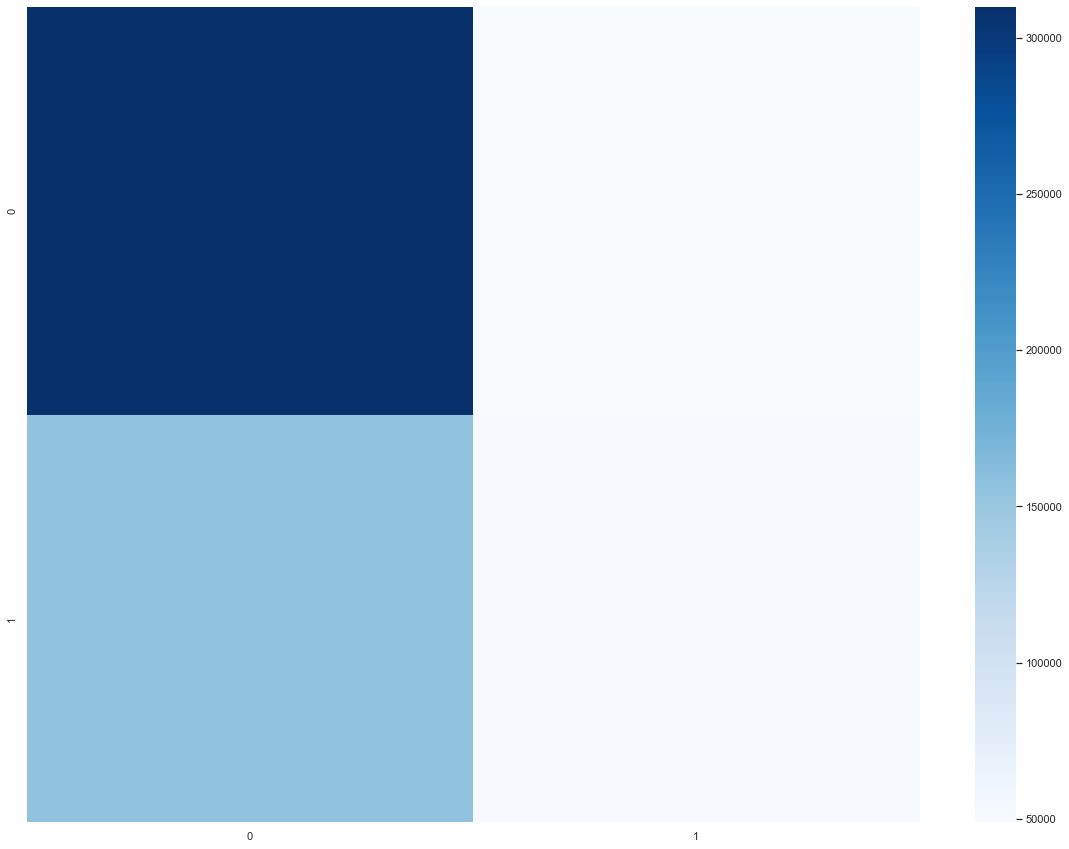

In [34]:
matrix = confusion_matrix(y_test,rf_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')

### K-Nearest Neighbors

In [35]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

In [36]:
print(classification_report(y_test,knn_y_pred))

              precision    recall  f1-score   support

           1       0.66      0.72      0.69    358743
           2       0.42      0.35      0.38    205779

    accuracy                           0.59    564522
   macro avg       0.54      0.54      0.53    564522
weighted avg       0.57      0.59      0.58    564522



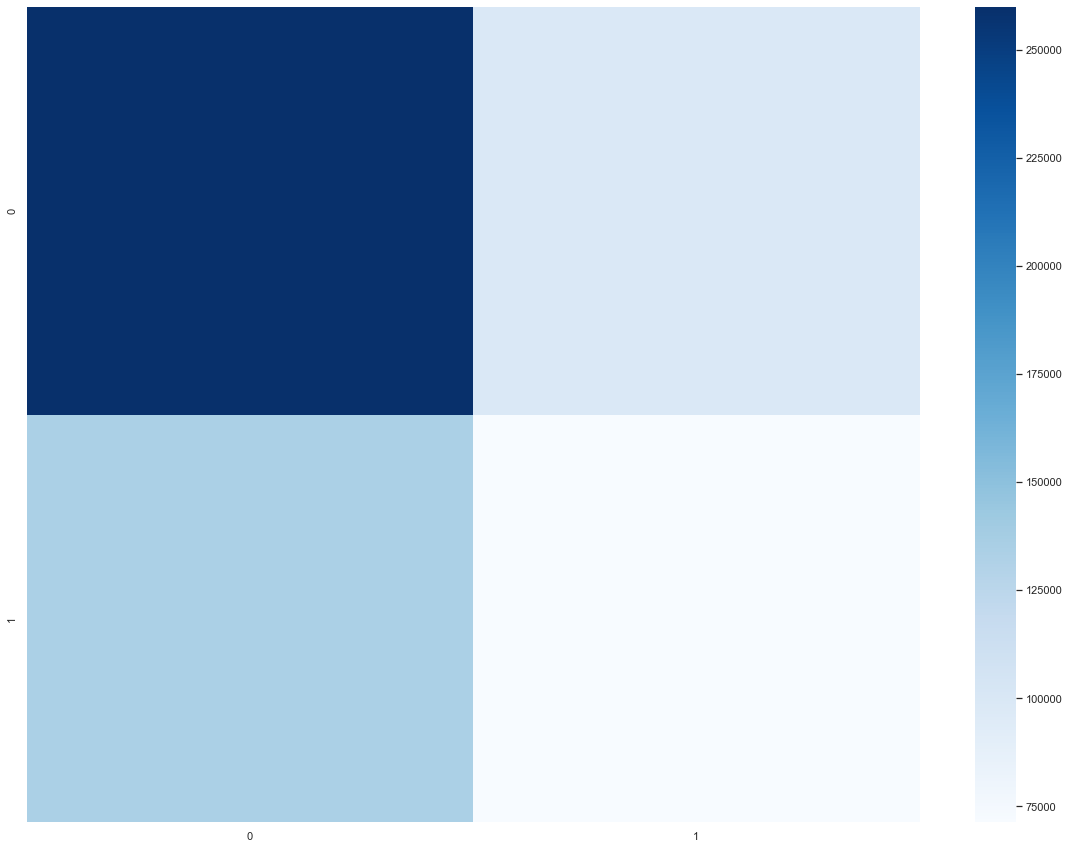

In [37]:
matrix = confusion_matrix(y_test,knn_y_pred)


plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix, cmap = 'Blues')